#  Oxford pets segmentation

In [2]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  20.5M      0  0:00:36  0:00:36 --:--:-- 21.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  7756k      0  0:00:02  0:00:02 --:--:-- 7759k


In [12]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 2 # change this
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


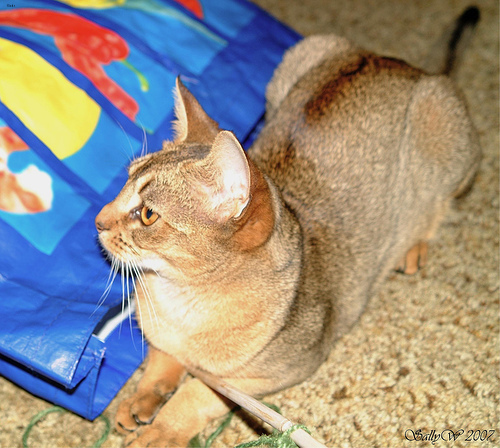

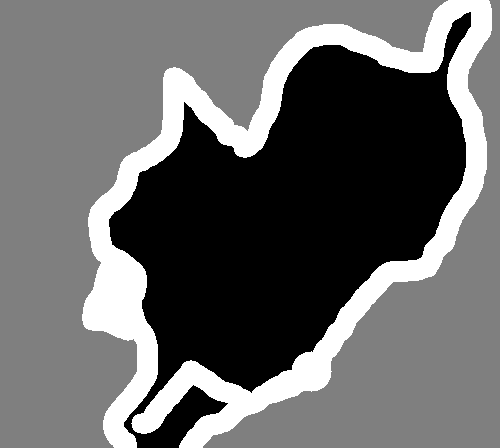

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [26]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            x[j] = np.expand_dims(img, 2)
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
            y1 = y[j] < 1
            y[j] = y1.astype(int)
        return x, y

In [32]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,)) #change to 1 from 3

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [182]:
## test the dataset generator

In [33]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
idxs = np.arange(len(input_img_paths))
random.Random(1337).shuffle(idxs)
random.Random(1337).shuffle(idxs)
train_input_img_paths = np.array(input_img_paths)[idxs][:-val_samples]
train_target_img_paths = np.array(target_img_paths)[idxs][:-val_samples]
val_input_img_paths = np.array(input_img_paths)[idxs][-val_samples:]
val_target_img_paths = np.array(target_img_paths)[idxs][-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [34]:
inp, tar = train_gen[0]

In [35]:
print(train_input_img_paths[:5])
train_target_img_paths[:5]

['images/Birman_69.jpg' 'images/yorkshire_terrier_185.jpg'
 'images/Ragdoll_107.jpg' 'images/german_shorthaired_173.jpg'
 'images/american_pit_bull_terrier_31.jpg']


array(['annotations/trimaps/Birman_69.png',
       'annotations/trimaps/yorkshire_terrier_185.png',
       'annotations/trimaps/Ragdoll_107.png',
       'annotations/trimaps/german_shorthaired_173.png',
       'annotations/trimaps/american_pit_bull_terrier_31.png'],
      dtype='<U54')

In [36]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 50s 233ms/step - loss: 0.7686 - val_loss: 3.5003
Epoch 2/15
199/199 [==============================] - 46s 232ms/step - loss: 0.3360 - val_loss: 1.6536
Epoch 3/15
199/199 [==============================] - 47s 233ms/step - loss: 0.2819 - val_loss: 0.2988
Epoch 4/15
199/199 [==============================] - 47s 236ms/step - loss: 0.2514 - val_loss: 0.2875
Epoch 5/15
199/199 [==============================] - 47s 235ms/step - loss: 0.2260 - val_loss: 0.2607
Epoch 6/15
199/199 [==============================] - 47s 236ms/step - loss: 0.2049 - val_loss: 0.2791
Epoch 7/15
199/199 [==============================] - 47s 237ms/step - loss: 0.1867 - val_loss: 0.2915
Epoch 8/15
199/199 [==============================] - 47s 237ms/step - loss: 0.1714 - val_loss: 0.2824
Epoch 9/15
199/199 [==============================] - 47s 236ms/step - loss: 0.1571 - val_loss: 0.2969
Epoch 10/15
132/199 [==================>...........] - ETA: 14s - loss: 0

KeyboardInterrupt: 

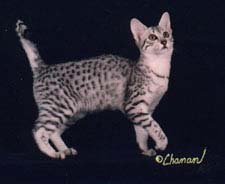

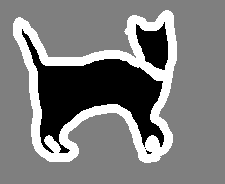

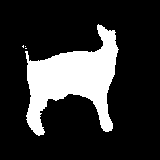

In [38]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 15

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [40]:
val_preds[15].shape

(160, 160, 2)

In [42]:
np.array(img).shape

(184, 225, 3)

In [44]:
inp, tar = val_gen[0]

In [48]:
inp[0].shape

(160, 160, 1)

In [49]:
tar[0].shape

(160, 160, 1)

In [51]:
np.unique(inp[0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [209]:
i = 5
mask = np.argmax(val_preds[i], axis=-1)
mask = np.expand_dims(mask, axis=-1)
np.unique(mask)

array([1])

In [208]:
val_preds[0,0,:]

array([[0.06014225, 0.7378709 , 0.20198692],
       [0.03392231, 0.7980485 , 0.16802917],
       [0.03209012, 0.80603933, 0.16187057],
       [0.03487472, 0.80116266, 0.16396265],
       [0.03262875, 0.8174844 , 0.14988683],
       [0.02745933, 0.84698343, 0.12555718],
       [0.02678269, 0.8477154 , 0.12550205],
       [0.03312324, 0.8607784 , 0.10609847],
       [0.03130557, 0.8467182 , 0.12197623],
       [0.02494693, 0.864167  , 0.11088607],
       [0.02498049, 0.86427915, 0.11074038],
       [0.02578653, 0.8764188 , 0.09779458],
       [0.02605346, 0.86920446, 0.10474213],
       [0.02259309, 0.87690747, 0.10049953],
       [0.02298289, 0.8755893 , 0.10142782],
       [0.02543374, 0.9061803 , 0.06838593],
       [0.02215118, 0.89762276, 0.08022597],
       [0.02705926, 0.9143132 , 0.05862752],
       [0.02939239, 0.9147579 , 0.05584976],
       [0.02828559, 0.9224301 , 0.04928433],
       [0.0267031 , 0.92314   , 0.05015691],
       [0.02662548, 0.9185177 , 0.05485691],
       [0.

In [32]:
inp, tar = val_gen[0]

In [36]:
np.unique(tar[0])

array([0, 1, 2], dtype=uint8)

In [104]:
# import tensorflow as tf

In [12]:
# from keras import backend as K
# # Configure the model for training.
# # We use the "sparse" version of categorical_crossentropy
# # because our target data is integers.
# def dice_coef(y_true, y_pred, smooth=1):
#     intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
#     union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
#     return tf.reduce_mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# # def mean_iou(y_true, y_pred):
# #     y_true = tf.cast(y_true, tf.dtypes.float64)
# #     y_pred = tf.cast(y_pred, tf.dtypes.float64)
# #     I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
# #     U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
# #     return tf.reduce_mean(I / U)

# def iou_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#     union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#     iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#     return iou


# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

In [ ]:
# # Configure the model for training.
# # We use the "sparse" version of categorical_crossentropy
# # because our target data is integers.
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=[dice_coef, iou_coef])

# callbacks = [
#     keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
# ]

# # Train the model, doing validation at the end of each epoch.
# epochs = 25
# history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

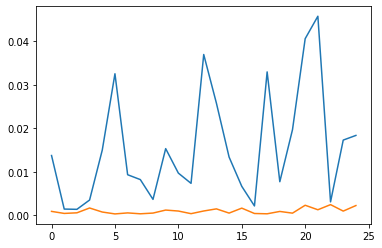

In [144]:
xr = np.arange(len(history.history['loss']))
plt.plot(xr, history.history['loss'])
plt.plot(xr, history.history['val_loss'])

2021-09-30 16:15:41.066238: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_167105"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  k

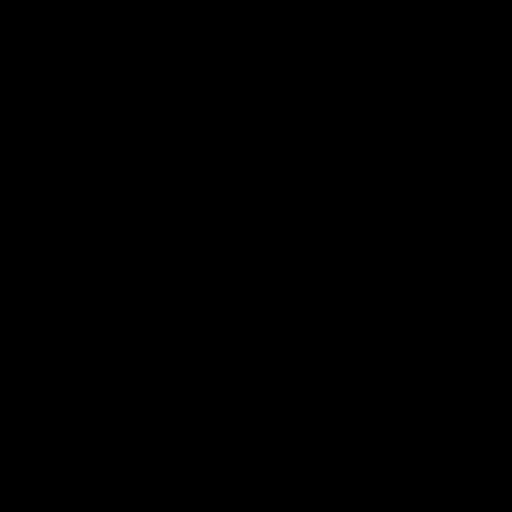

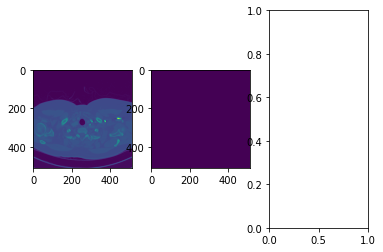

In [112]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

f, a = plt.subplots(1,3)
# Display input image
#display(Image(filename=val_input_img_paths[i]))
a[0].imshow(load_img(val_input_img_paths[i]))

# Display ground-truth target mask
# img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# display(img)

a[1].imshow(load_img(val_target_img_paths[i]))

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [115]:
i, t = train_gen[24]

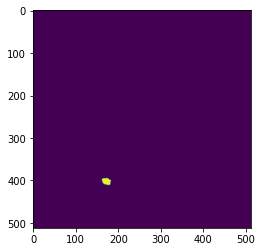

In [118]:
plt.imshow(t[22])

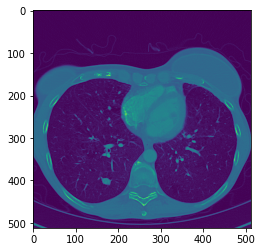

In [119]:
plt.imshow(i[22])

In [128]:
i[22].shape

(512, 512, 1)

In [132]:
model.predict(np.expand_dims(i[22], 0))

2021-09-30 16:22:29.869089: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_170969"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

(1, 512, 512, 2)

In [141]:
pred_max = np.argmax(val_preds[0], -1)
np.max(pred_max)

0

2021-09-30 16:23:37.301004: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_172649"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

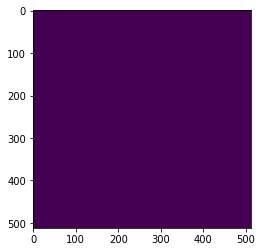

In [140]:
val_preds = model.predict(np.expand_dims(i[22], 0))
mask = np.argmax(val_preds[0], axis=-1)
mask = np.expand_dims(mask, axis=-1)
plt.imshow(mask)
# def display_mask(i):
#     """Quick utility to display a model's prediction."""
#     mask = np.argmax(val_preds[i], axis=-1)
#     mask = np.expand_dims(mask, axis=-1)
#     img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
#     display(img)

In [131]:
i, t = train_gen[0]
print(i[0].shape)
print(np.expand_dims(i[0], 0).shape)

(512, 512, 1)
(1, 512, 512, 1)


In [123]:
val_preds.shape

(512, 512, 16, 2)

In [77]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [78]:
val_preds.shape

(996, 512, 512, 2)

In [ ]:
val_preds = model.predict(val_gen[0])

In [87]:
i, t = val_gen[0]

In [89]:
model.predict(i).shape

(12, 512, 512, 2)

In [90]:
i, t = train_gen[0]

In [92]:
i.shape

(12, 512, 512, 1)

In [100]:
i[0].shape
np.expand_dims(i[0], 0).shape

(1, 512, 512, 1)

In [101]:
model.predict(np.expand_dims(i[0], 0)).shape

(1, 512, 512, 2)

In [79]:
val_preds[0]

(160, 160, 3)

In [84]:
model.output_shape

(None, 160, 160, 3)

In [83]:
model.predict(np.expand_dims(val_preds[0], 0))

array([[[[0.0112998 , 0.9631687 , 0.02553156],
         [0.00477917, 0.9753523 , 0.01986846],
         [0.00515414, 0.9764854 , 0.01836045],
         ...,
         [0.00434882, 0.9827481 , 0.01290311],
         [0.00319181, 0.98493594, 0.01187229],
         [0.0059328 , 0.92281115, 0.07125609]],

        [[0.0170232 , 0.93975896, 0.04321784],
         [0.00439123, 0.9916933 , 0.00391542],
         [0.0054017 , 0.991355  , 0.0032433 ],
         ...,
         [0.00616232, 0.9857113 , 0.00812639],
         [0.00652728, 0.98573864, 0.00773416],
         [0.00351562, 0.9861107 , 0.01037364]],

        [[0.01528398, 0.95362705, 0.03108902],
         [0.00289179, 0.9941969 , 0.00291125],
         [0.0045605 , 0.9927527 , 0.00268681],
         ...,
         [0.00908099, 0.97904587, 0.01187316],
         [0.00669536, 0.9839512 , 0.00935339],
         [0.0045876 , 0.97835666, 0.01705575]],

        ...,

        [[0.05897732, 0.89114255, 0.0498802 ],
         [0.03139471, 0.9406599 , 0.02794548]

In [13]:
img, mask = val_gen[0]

In [14]:
img.shape

(32, 160, 160, 3)

In [17]:
img[0].shape

(160, 160, 3)

In [21]:
import tensorflow as tf

In [26]:
inp = np.expand_dims(img[0], 0)
print(inp.shape)
model.predict(inp).shape

(1, 160, 160, 3)


(1, 160, 160, 3)